Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Kerala Floods Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/kerala_floods_2018_train.tsv"
dev_path = "/content/kerala_floods_2018_dev.tsv"
test_path = "/content/kerala_floods_2018_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,1031218893908406273,"Kerala Floods: More than 38,000 people rescued...",rescue_volunteering_or_donation_effort
1,1030767523342499842,@BDUTT While PayTm owner Shekhar donated Rs Te...,rescue_volunteering_or_donation_effort
2,1030385981973618688,#KeralaFloods Malayala Manorama makes epaper f...,rescue_volunteering_or_donation_effort
3,1031078567147319297,#KeralaSOS #KeralaFloods Lets centralise all r...,sympathy_and_support
4,1033187418889834497,@narendramodi @AmitShah PS @ kerala is doing t...,rescue_volunteering_or_donation_effort
...,...,...,...
6397,1030786300616499200,These fishermen are the unsung heroes of #Kera...,rescue_volunteering_or_donation_effort
6398,1030962909369827328,Huge water and food requirement would be there...,requests_or_urgent_needs
6399,1030717914041659394,@PiyushGoyal we are ready to give one day sala...,rescue_volunteering_or_donation_effort
6400,1032292488772431872,"Flood in Kerala :about 900,000. people were in...",injured_or_dead_people


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,1032436206313725953,Please help my uncle and aunt stranded in Kott...,requests_or_urgent_needs
1,1035526412445220865,Asian Games : Seema Punia to donate 1 lakh rup...,rescue_volunteering_or_donation_effort
2,1033158595146219520,Happy Onam to all our sisters&amp;brothers in ...,rescue_volunteering_or_donation_effort
3,1031034992535789570,These are the precautions issued by the Direct...,caution_and_advice
4,1032557601660133376,RT @eastcoastrail: .@RailMinIndia Relief mater...,rescue_volunteering_or_donation_effort
...,...,...,...
1577,1031800123196506113,"The first truck carrying relief materials, mob...",rescue_volunteering_or_donation_effort
1578,1030405410920878082,"7. @RailMinIndia has provided 1,20,000 water b...",requests_or_urgent_needs
1579,1030802853802037249,@TomCruise #KeralaFloodRelief #KeralaFloods SI...,requests_or_urgent_needs
1580,1033036337753010177,"#KeralaFloods: 7,000 houses fully damaged and ...",infrastructure_and_utility_damage


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,4294
other_relevant_information,955
sympathy_and_support,835
requests_or_urgent_needs,590
not_humanitarian,456
injured_or_dead_people,363
infrastructure_and_utility_damage,296
caution_and_advice,139
displaced_people_and_evacuations,56


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

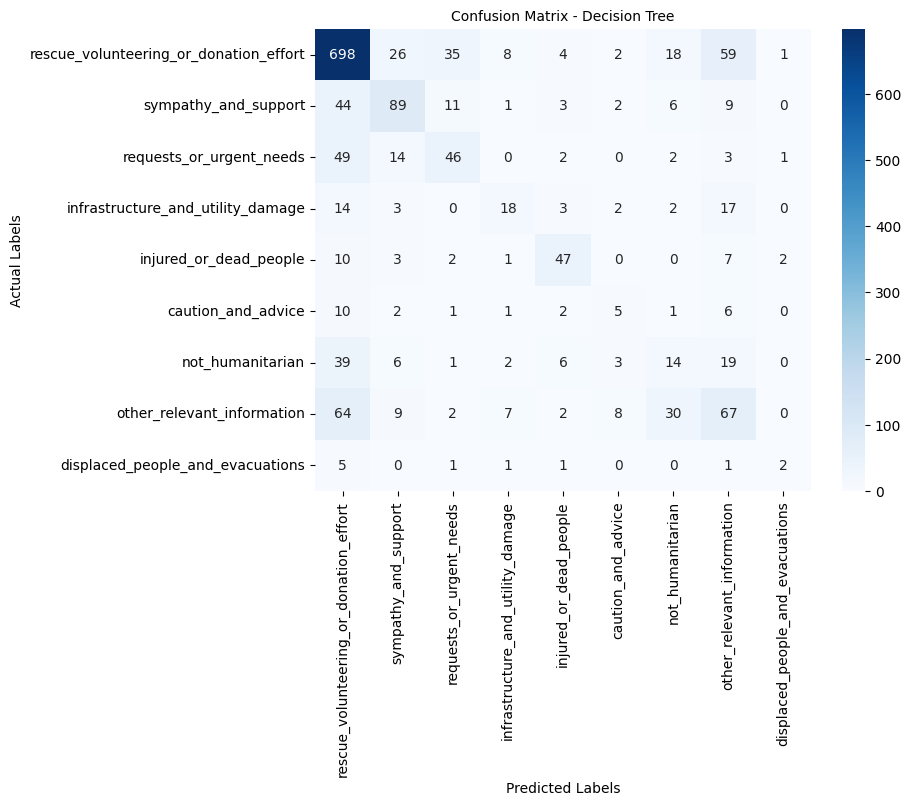


Decision Tree Evaluation:
Accuracy: 0.6232616940581542
Precision: 0.6054676799965154
F1 Score: 0.6122387699168821

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.75      0.82      0.78       851
                  sympathy_and_support       0.59      0.54      0.56       165
              requests_or_urgent_needs       0.46      0.39      0.43       117
     infrastructure_and_utility_damage       0.46      0.31      0.37        59
                injured_or_dead_people       0.67      0.65      0.66        72
                    caution_and_advice       0.23      0.18      0.20        28
                      not_humanitarian       0.19      0.16      0.17        90
            other_relevant_information       0.36      0.35      0.36       189
      displaced_people_and_evacuations       0.33      0.18      0.24        11

                              accuracy                    

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

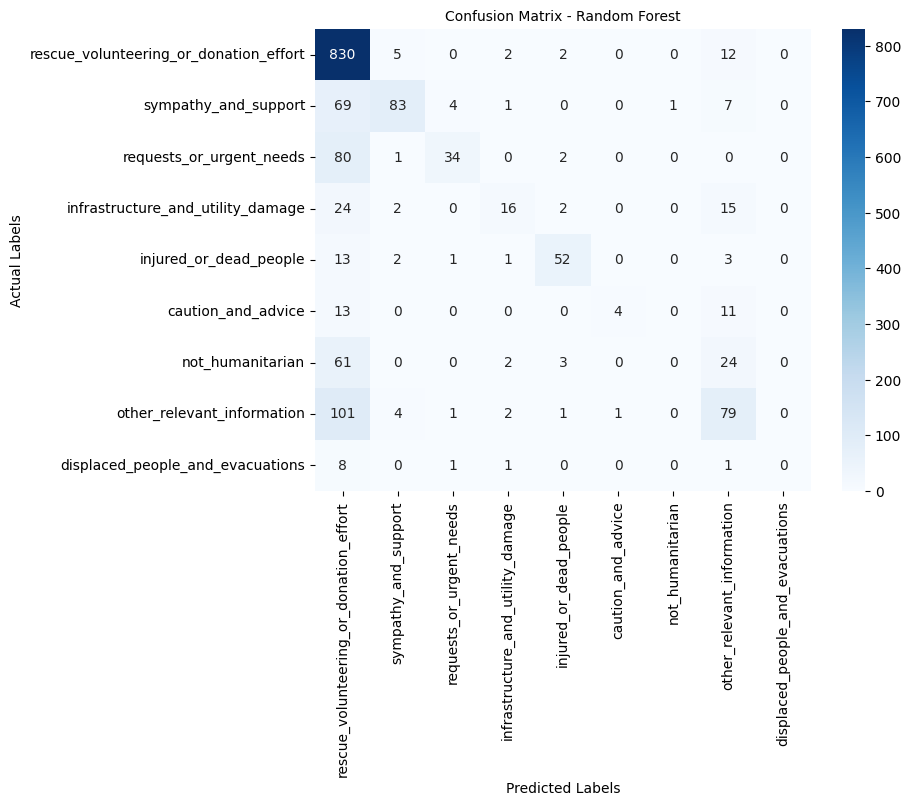


Random Forest Evaluation:
Accuracy: 0.6940581542351454
Precision: 0.6612430888500498
F1 Score: 0.6426772237188922

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.69      0.98      0.81       851
                  sympathy_and_support       0.86      0.50      0.63       165
              requests_or_urgent_needs       0.83      0.29      0.43       117
     infrastructure_and_utility_damage       0.64      0.27      0.38        59
                injured_or_dead_people       0.84      0.72      0.78        72
                    caution_and_advice       0.80      0.14      0.24        28
                      not_humanitarian       0.00      0.00      0.00        90
            other_relevant_information       0.52      0.42      0.46       189
      displaced_people_and_evacuations       0.00      0.00      0.00        11

                              accuracy                    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

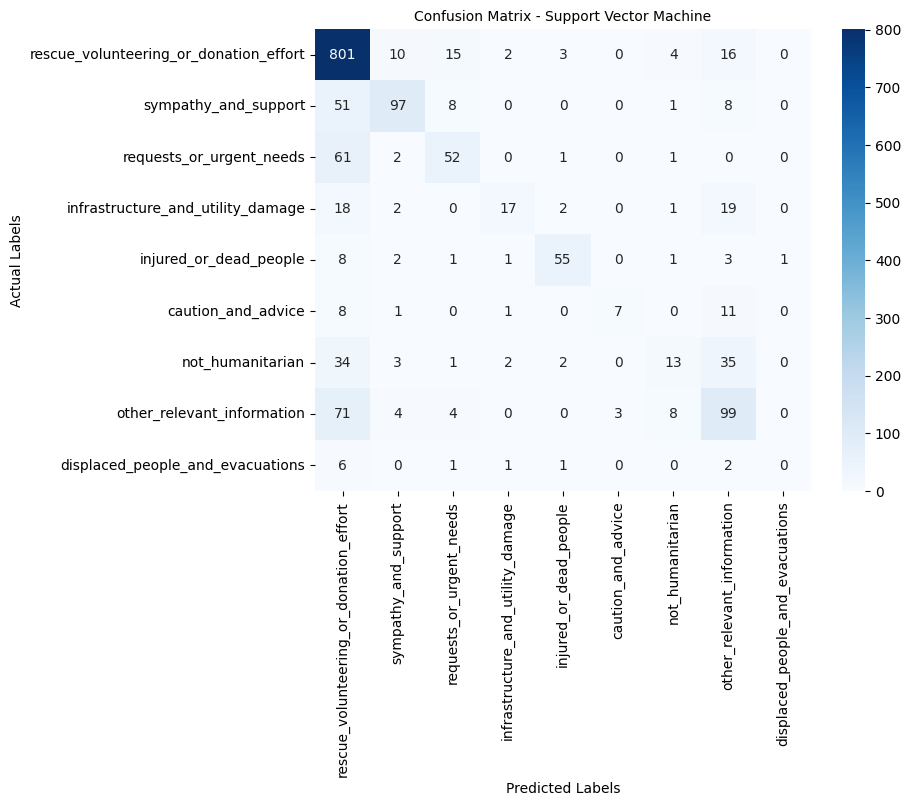


Support Vector Machine Evaluation:
Accuracy: 0.7212389380530974
Precision: 0.7024716426681226
F1 Score: 0.6937802518971121

 Classification Report:
                                        precision    recall  f1-score   support

rescue_volunteering_or_donation_effort       0.76      0.94      0.84       851
                  sympathy_and_support       0.80      0.59      0.68       165
              requests_or_urgent_needs       0.63      0.44      0.52       117
     infrastructure_and_utility_damage       0.71      0.29      0.41        59
                injured_or_dead_people       0.86      0.76      0.81        72
                    caution_and_advice       0.70      0.25      0.37        28
                      not_humanitarian       0.45      0.14      0.22        90
            other_relevant_information       0.51      0.52      0.52       189
      displaced_people_and_evacuations       0.00      0.00      0.00        11

                              accuracy           

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")